<center><h1>Projet Robotique</h1></center>
<center><h2>Classification via GRU</h2></center>

# Importation des librairies

In [ ]:
!pip install bayesian-optimization

In [ ]:
import os
from google.colab import drive

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from bayes_opt import BayesianOptimization

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')
# disable tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Configaration GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Robotique/preprocessed_data.csv")

df

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer RKN^ accZ,Accelerometer HIP accX,Accelerometer HIP accY,Accelerometer HIP accZ,Accelerometer LUA^ accX,Accelerometer LUA^ accY,Accelerometer LUA^ accZ,...,LOCATION TAG4 X,LOCATION TAG4 Y,LOCATION TAG4 Z,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,-1.410530,0.693260,0.434434,0.074936,-0.199117,0.621667,-0.455638,...,0.147947,0.811792,0.186199,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,-1.626921,0.626338,0.487110,0.200034,-0.108635,0.598101,-0.542260,...,0.147947,0.812691,0.178270,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,-1.735116,0.470187,0.527630,0.179184,-0.099275,0.709202,-0.572130,...,0.147947,0.814490,0.172322,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,-1.616313,0.618902,0.523578,0.210459,-0.152316,0.729402,-0.593039,...,0.147947,0.816289,0.172322,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,-1.705415,0.570570,0.535734,0.161809,-0.189757,0.709202,-0.634857,...,0.149055,0.818988,0.176287,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,-0.141884,0.358651,0.102168,0.787298,0.418657,0.540867,-0.067329,...,0.129671,0.139901,0.208006,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,-0.020960,0.291729,0.102168,0.776873,0.452977,0.483633,-0.195770,...,0.129117,0.138102,0.206023,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,-0.001866,0.143014,0.110272,0.915871,0.393696,0.503833,-0.195770,...,0.129117,0.136303,0.202059,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,-0.046417,0.098399,0.256145,0.780348,0.362495,0.577900,-0.276418,...,0.129671,0.134504,0.200076,0,0,0,0,0,0,0


# Fonctions diverses

# Fonctions de feature selection

In [ ]:
def dim_reduction(df, n):
  pca = PCA(n_components=n)
  pca.fit(df)
  reducted_df = pca.fit_transform(df)
  columns_name = ['column'+str(i) for i in range(1, pca.n_components_+1)]
  return pd.DataFrame(reducted_df, columns=columns_name)


In [ ]:
def correlation(dataset, cor):
    df = dataset.copy()
    col_corr = set()  # For storing unique value
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > cor: # absolute values to handle positive and negative correlations
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    df.drop(col_corr,axis = 1,inplace = True)
    return df

## Fonction de segmentation du dataset  

In [ ]:
def data_segmentation(dataCollection, window_size, label): # segment the data and create a dataset with locomotion classes as labels

    loco_i = dataCollection.columns.get_loc(label)
    #convert the data frame to numpy array
    data = dataCollection.to_numpy()
    #segment the data
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0

    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][loco_i] == data[end][loco_i] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the file
            X.append(data[start:(end+1),:])
            y.append(data[start][loco_i])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][loco_i] != data[start+1][loco_i]:
                    break
                start += 1
            start += 1

    return np.asarray(X), np.asarray(y)

## Fonction d'entrainement du modèle

In [ ]:
def gru_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, v):
  nbn_l = int(nbn_l)
  nbn_d = int(nbn_d)
  bs = int(bs)
  with tf.device(device_name):

    model = Sequential()

    model.add(GRU(units=nbn_l, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

    model.add(GRU(units=nbn_l//2, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

    model.add(GRU(units=nbn_l//4, activation='tanh', return_sequences=True, input_shape=X_train[0].shape))

    model.add(GRU(units=nbn_l//8, activation='tanh'))

    model.add(Flatten())
    model.add(Dense(nbn_d, activation='elu'))
    model.add(Dropout(dp))
    model.add(Dense(nbn_l//2, activation='elu'))
    model.add(Dropout(dp))
    model.add(Dense(5, activation='softmax'))


    model.compile(optimizer = Adam(learning_rate=lr),
                  loss = 'categorical_crossentropy',
                  metrics =[tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'),
                        'accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])

    checkpointer = ModelCheckpoint(filepath='test.keras', monitor='accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

    history = model.fit(X_train, y_train,
                            batch_size=bs, epochs=100,
                            verbose=v,
                            callbacks = [checkpointer, early],
                            validation_data=(X_val, y_val))

    return history, model

## Fonction de la pipeline à utiliser

In [ ]:
def pipeline(method,tresh,nbn_l, nbn_d, lr, bs, dp):

  if method <= 1:
    dataset = dim_reduction(df[df.columns[:-7]], tresh)
  elif method <= 2:
    dataset = correlation(df[df.columns[:-7]], tresh)

  labels = df[df.columns[-7:]]
  dataset = pd.concat([dataset, labels], axis=1)

  X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

  y = to_categorical(y)

  # split the data into train, validation and test sets using sklearn
  X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

  history, model = gru_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 0)
  acc = history.history['val_accuracy'][-1]

  return acc

# Affinage de la pipeline via l'optimisation Bayesienne

In [ ]:
pbounds = {
    'method': (0, 2),
    'tresh': (0.1, 0.99),
    'nbn_l': (256, 1024),
    'nbn_d': (256, 1024),
    'lr': (1e-6, 1e-2),
    'bs': (32, 512),
    'dp': (0.1, 0.5)
    }


optimizer = BayesianOptimization(
    f=pipeline,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)
print(optimizer.max)

|   iter    |  target   |    bs     |    dp     |    lr     |  method   |   nbn_d   |   nbn_l   |   tresh   |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7474    | 232.2     | 0.3881    | 2.144e-06 | 0.6047    | 368.7     | 326.9     | 0.2658    |
| 2         | 0.9794    | 197.9     | 0.2587    | 0.005389  | 0.8384    | 782.2     | 413.0     | 0.8815    |
| 3         | 0.9985    | 45.15     | 0.3682    | 0.004174  | 1.117     | 363.8     | 408.1     | 0.8127    |
| 4         | 1.0       | 496.8     | 0.2254    | 0.006924  | 1.753     | 943.1     | 321.3     | 0.1348    |
| 5         | 0.9927    | 113.5     | 0.4513    | 0.0009844 | 0.8422    | 991.7     | 665.5     | 0.7158    |
| 6         | 0.975     | 183.4     | 0.3746    | 0.008346  | 0.03658   | 832.1     | 1.015e+03 | 0.7659    |
| 7         | 0.9985    | 166.6     | 0.4157    | 0.001033  | 0.8958    | 953.8     | 481.5     | 0.3561    |
| 8       

# Préparation du dataset pour l'entrainement avec les hyperparamètres optimaux

## Feature selection

In [ ]:
method = optimizer.max['params']['method']
tresh = optimizer.max['params']['tresh']

if method <= 1:
  dataset = dim_reduction(df[df.columns[:-7]], tresh)
elif method <= 2:
  dataset = correlation(df[df.columns[:-7]], tresh)

labels = df[df.columns[-7:]]
dataset = pd.concat([dataset, labels], axis=1)

dataset

,MILLISEC,Accelerometer RKN^ accX,Accelerometer RKN^ accY,Accelerometer HIP accX,InertialMeasurementUnit BACK gyroX,InertialMeasurementUnit L-SHOE Nav_Ax,InertialMeasurementUnit L-SHOE Nav_Ay,InertialMeasurementUnit L-SHOE Nav_Az,InertialMeasurementUnit L-SHOE AngVelBodyFrameZ,InertialMeasurementUnit R-SHOE Nav_Ax,...,Accelerometer DOOR2 accY,Accelerometer UPPERDRAWER accX,Accelerometer LOWERDRAWER accX,Locomotion,HL_Activity,LL_Left_Arm,LL_Left_Arm_Object,LL_Right_Arm,LL_Right_Arm_Object,ML_Both_Arms
0,-1.585284,0.146747,0.337532,0.693260,-0.221680,0.600405,0.094571,-0.312776,2.280966,0.024974,...,-0.034580,-0.528598,-0.321718,0,0,0,0,0,0,0
1,-1.585185,0.263802,0.342378,0.626338,-0.228620,-0.196844,-0.040467,0.153620,1.707885,0.017984,...,0.034665,-0.528598,-0.321718,0,0,0,0,0,0,0
2,-1.585083,0.194202,0.371457,0.470187,-0.226885,-0.229964,-0.031464,-0.014929,1.105162,0.024974,...,1.558045,-0.528598,-0.321718,0,0,0,0,0,0,0
3,-1.584985,0.058164,0.153369,0.618902,-0.107165,-0.222867,0.065313,-0.040327,0.539986,0.034294,...,0.657866,-0.528598,-0.063922,0,0,0,0,0,0,0
4,-1.584886,0.247984,0.290684,0.570570,-0.081138,-0.608480,-0.234021,0.040484,0.313718,0.017984,...,0.242398,-0.528598,-0.321718,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606043,1.407215,0.640278,0.298761,0.358651,0.029907,-0.078558,-0.022462,0.209033,-0.058785,0.004005,...,-1.073249,-0.160163,-0.321718,0,0,0,0,0,0,0
606044,1.407317,0.437804,0.297145,0.291729,0.002146,-0.111678,-0.074226,0.271373,-0.176365,0.024974,...,0.242398,0.899089,-0.321718,0,0,0,0,0,0,0
606045,1.407416,0.678242,0.240604,0.143014,0.092370,-0.222867,-0.047219,0.301389,-0.114117,0.013324,...,-0.311558,0.254327,-0.321718,0,0,0,0,0,0,0
606046,1.407514,1.155955,0.159831,0.098399,0.113191,-0.158992,-0.060722,0.174400,-0.125973,0.001675,...,-0.311558,0.162218,0.022009,0,0,0,0,0,0,0


## Segmentation du dataset

In [ ]:
X, y = data_segmentation(dataCollection=dataset, window_size=25, label='HL_Activity')

X.shape, y.shape

((4122, 25, 39), (4122,))

## Division des données en train, val et test sets

In [ ]:
# categorize the data
y = to_categorical(y)

# split the data into train, validation and test sets using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=True, test_size=0.5)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", X_train.shape)
print("Shape of the validation set: ", X_val.shape)
print("Shape of the test set: ", X_test.shape)

# display the shape of the train, validation and test sets
print("Shape of the train set: ", y_train.shape)
print("Shape of the validation set: ", y_val.shape)
print("Shape of the test set: ", y_test.shape)

Shape of the train set:  (2761, 25, 39)
Shape of the validation set:  (681, 25, 39)
Shape of the test set:  (680, 25, 39)
Shape of the train set:  (2761, 5)
Shape of the validation set:  (681, 5)
Shape of the test set:  (680, 5)


# Entrainement du dataset avec les hyperparamètres optimaux

In [ ]:
nbn_l = optimizer.max['params']['nbn_l']
nbn_d = optimizer.max['params']['nbn_d']
lr = optimizer.max['params']['lr']
dp = optimizer.max['params']['dp']
bs =optimizer.max['params']['bs']

history, model = gru_model(X_train, y_train, X_val, y_val, nbn_l, nbn_d, lr, bs, dp, 2)

Epoch 1/100
6/6 - 11s - loss: 3.0500 - tp: 1000.0000 - fp: 1092.0000 - tn: 9952.0000 - fn: 1761.0000 - accuracy: 0.4064 - precision: 0.4780 - recall: 0.3622 - auc: 0.6628 - val_loss: 1.3039 - val_tp: 425.0000 - val_fp: 234.0000 - val_tn: 2490.0000 - val_fn: 256.0000 - val_accuracy: 0.6432 - val_precision: 0.6449 - val_recall: 0.6241 - val_auc: 0.8747 - 11s/epoch - 2s/step
Epoch 2/100
6/6 - 0s - loss: 1.0480 - tp: 1814.0000 - fp: 730.0000 - tn: 10314.0000 - fn: 947.0000 - accuracy: 0.6777 - precision: 0.7131 - recall: 0.6570 - auc: 0.9026 - val_loss: 0.6137 - val_tp: 489.0000 - val_fp: 78.0000 - val_tn: 2646.0000 - val_fn: 192.0000 - val_accuracy: 0.8076 - val_precision: 0.8624 - val_recall: 0.7181 - val_auc: 0.9556 - 332ms/epoch - 55ms/step
Epoch 3/100
6/6 - 0s - loss: 0.5705 - tp: 1996.0000 - fp: 406.0000 - tn: 10638.0000 - fn: 765.0000 - accuracy: 0.7711 - precision: 0.8310 - recall: 0.7229 - auc: 0.9597 - val_loss: 0.3913 - val_tp: 557.0000 - val_fp: 95.0000 - val_tn: 2629.0000 - va

# Evaluation du modèle

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01147029921412468
Test accuracy: 679.0


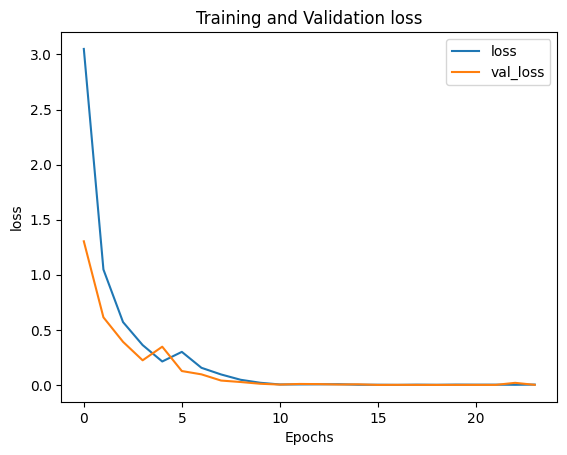

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation loss')
plt.show()

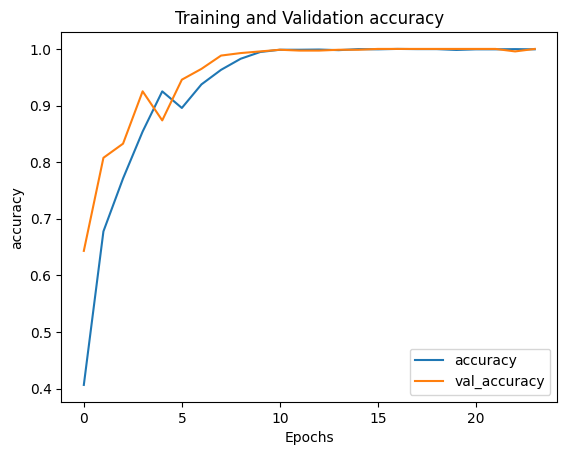

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation accuracy')
plt.show()

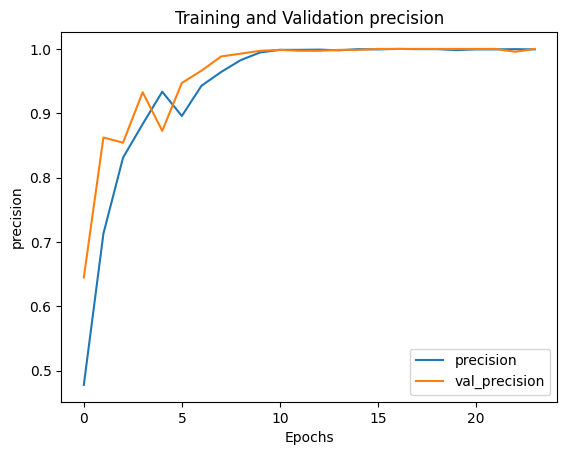

In [ ]:
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='Validation precision')
plt.xlabel("Epochs")
plt.ylabel('precision')
plt.legend(['precision', 'val_precision'])
plt.title('Training and Validation precision')
plt.show()

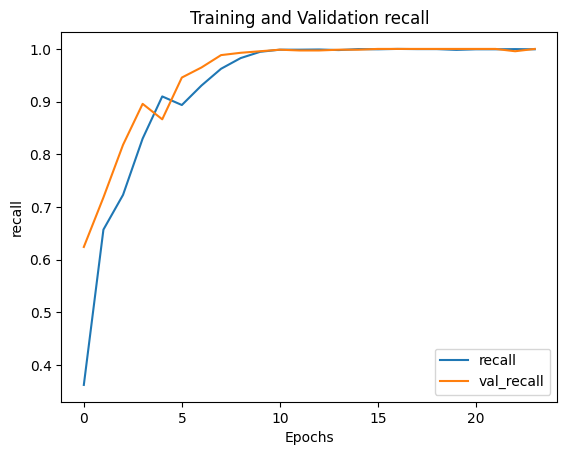

In [ ]:
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='Validation recall')
plt.xlabel("Epochs")
plt.ylabel('recall')
plt.legend(['recall', 'val_recall'])
plt.title('Training and Validation recall')
plt.show()

22/22 [==============================] - 2s 6ms/step
Confusion Matrix
Accuracy for Test Data =  99.8529411764706


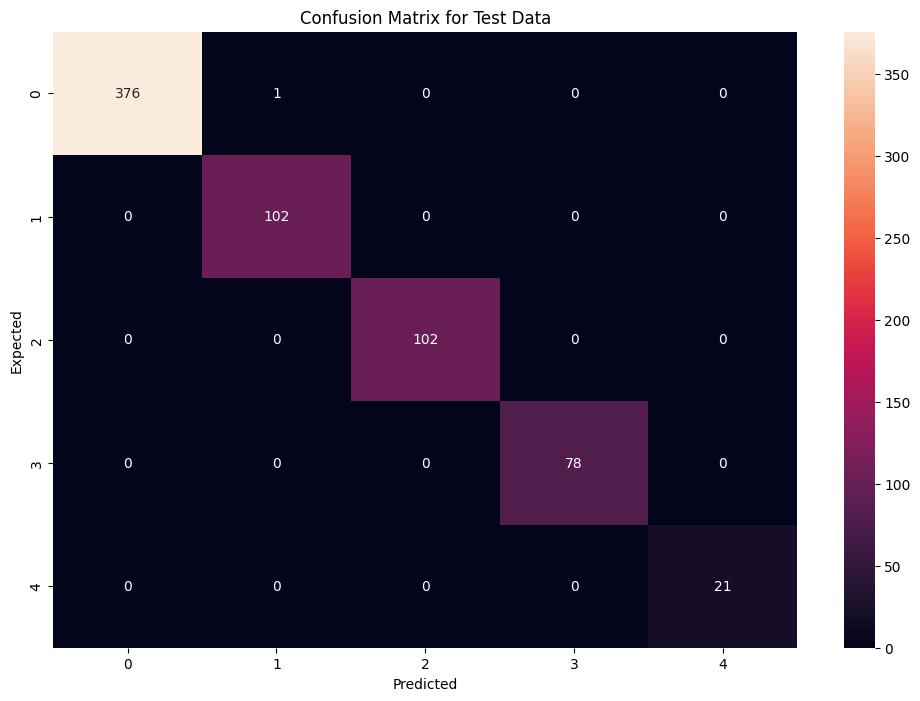


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       377
           1       0.99      1.00      1.00       102
           2       1.00      1.00      1.00       102
           3       1.00      1.00      1.00        78
           4       1.00      1.00      1.00        21

    accuracy                           1.00       680
   macro avg       1.00      1.00      1.00       680
weighted avg       1.00      1.00      1.00       680


Cohen Kappa Score
0.9976808668101346

Precision vs Recall Curve


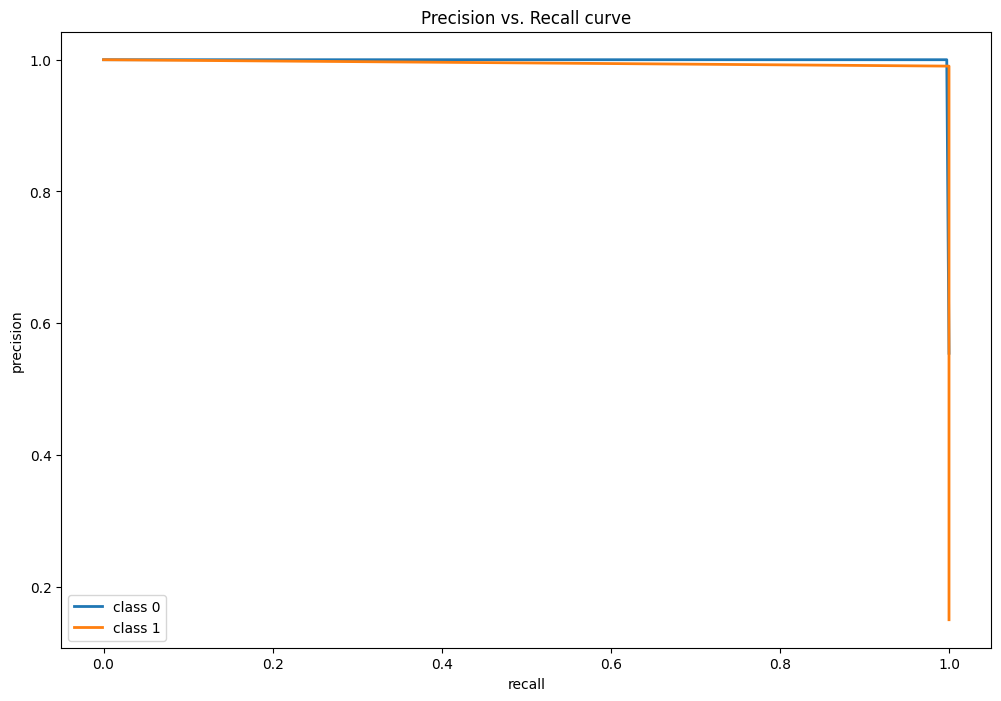


ROC Curve
ROC AUC score: 0.9995617376299872


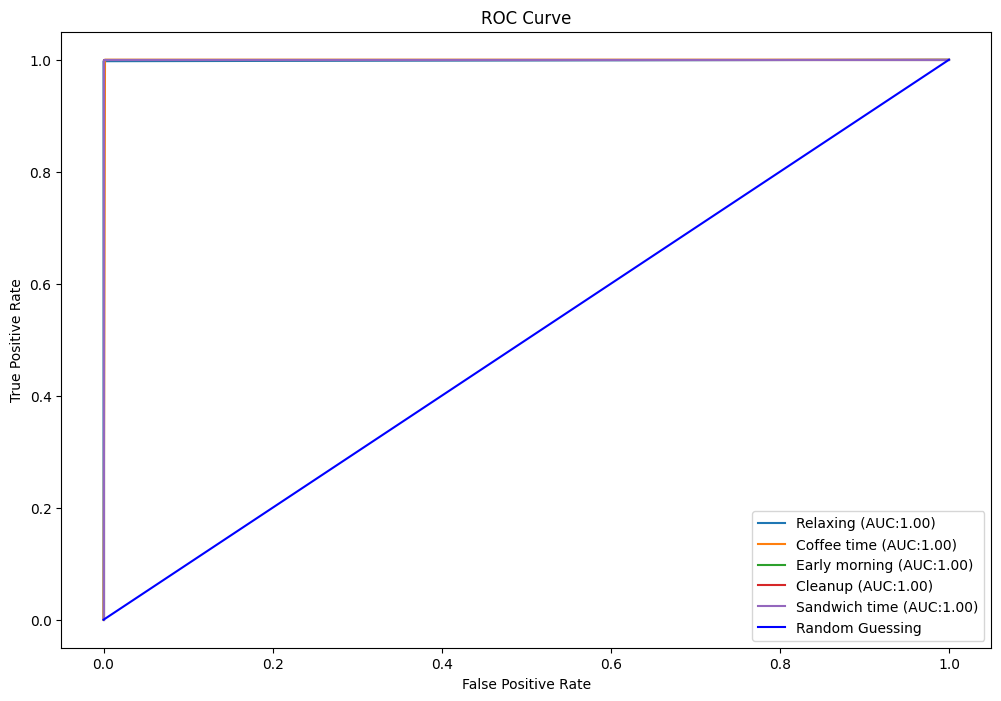

In [ ]:
def model_evaluate(model, target, testX, testy):
  y_pred = model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(testy, axis=1)

  # Confusion matrix
  print('Confusion Matrix')

  cm = confusion_matrix(y_test, y_pred)
  # Calculate accuracy
  from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_curve, auc, roc_auc_score, precision_recall_curve
  conf_acc = accuracy_score(y_test, y_pred) * 100
  print("Accuracy for Test Data = ", conf_acc)

  plt.figure(figsize = (12,8))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  # Classification Report
  print('\nClassification Report')
  print(classification_report(y_test, y_pred))

  # Cohen Kappa Score
  print('\nCohen Kappa Score')
  print(cohen_kappa_score(y_test, y_pred))

  # Precision vs Recall Curve
  print('\nPrecision vs Recall Curve')
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

  y_test = tf.keras.utils.to_categorical(y_test)
  y_pred = tf.keras.utils.to_categorical(y_pred)
  n_classes = 2

  precision = dict()
  recall = dict()

  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                          y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("Precision vs. Recall curve")
  plt.show()

  # ROC Curve
  print('\nROC Curve')
  average = 'macro'
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
  for (idx, c_label) in enumerate(target):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

model_evaluate(model, ['Relaxing', 'Coffee time', 'Early morning', 'Cleanup', 'Sandwich time'], X_test, y_test)

In [ ]:
pd.DataFrame([[history.history['loss'][-1], history.history['accuracy'][-1], history.history['precision'][-1], history.history['recall'][-1], history.history['tp'][-1], history.history['tn'][-1], history.history['fn'][-1], history.history['fp'][-1], history.history['auc'][-1]]],  columns=["loss", "accuracy", "precision", "recall", "true positive", "true negative", "false positive", "false negative", "area under the curve"])

,loss,accuracy,precision,recall,true positive,true negative,false positive,false negative,area under the curve
0,0.00327,0.999276,0.999276,0.999276,2759.0,11042.0,2.0,2.0,0.999773
